# Informações do Autor
Autor do código: Marco Antonio Siriani NUSP:8927791

Estudante de Engenharia da Computação na EESC-USP

# Bibliotecas utilizadas
- A biblioteca entropy_estimators.py foi escrita por Greg Ver Steeg. Link do GitHub: https://github.com/gregversteeg/NPEET/blob/master/npeet/entropy_estimators.py


- A biblioteca nolitsa foi escrita por Manu Mannattil. Link do GitHub:
https://github.com/manu-mannattil/nolitsa

# Descrição do problema
A previsão do mercado de ações é um grande desafio na área de finanças por ser totalmente incerto. O objetivo é 
implemetar três modelos: SVR, Random Forest e Boosted Decison Tree, utilizando a base histórica dos preços das ações para
estimar seu preço no futuro / sua tendência.
# Estratégia de Solução
Para realizar a predição do preço da ação deve-se constatar a existência de dependência temporal dos dados, se os dados forem puramente determinísticos basta aplicar o teorema de Takens e modelar, caso os dados tenham componentes estocásticos e determinísticos, deve-se decompô-los (determínistico + estocástico) e após a decomposição realizar os passos anteriormente ditos.
Sendo assim, a solução será dada pelos seguintes passos:

1 - Coleta dos dados do site Yahoo Finance;

2 - Apenas a coluna do preço final do dia será utilizada para a predição;

3 - Aplicar EMD (Empirical Mode Decomposition), para decompor em Estocástico e Determinístico criando as 
    Intrinsic Mode Functions (IMFs);
    
4 - Aplicar a Transformada de Fourier em cada IMF;

5 - Calcular as fases dessas transformadas;

6 - Calcular a Mutual Information entre as fases subsequentes, esse grau de similaridade fornecerá o valor para selecionar
    a parte estocástica e a parte determinística;
    
7 - Calcular MI na parte determinística para apresentar a dependência temporal, o primeiro mínimo local é um bom candidato
    para time delay, o time delay evidencia qual o deslocamento de tempo que o ponto tem dependência com outro 
    ponto(Colocar o artigo);
    
8 - Calcular o false nearest neighbor (FNN), valor abaixo de 0,2 já é bom para utilizar como dimensão;

9 - Aplicar o teorema de Takens com as melhores variáveis de time delay e dimensão encontradas através de MI e FNN;

10 - As variáveis de entrada para treino serão todas as colunas, exceto a útilma, e as variáveis de saída para treino será
     a última coluna;
     
11 - As entradas para a predição dos valores serão escolhidas coletando o número de instantes de tempo, equivalente ao 
     valor do time delay, anteriores localizados nas colunas m-1 e m, sendo m o número de dimensões. No exemplo abaixo, as 
     entradas 4 e 6 foram utilizadas a predição de x, visto que ela ocorreram a dois instantes de tempo atrás.

        x(t)|x(t+2)|x(t+4)
             
         1  |   3  |   5
            -------------
         2  |   4  |   6
            -------------
         3  |   5  |   7
         -----------
         4  |   6  |   x
         -----------
         5  |   7  |   y
         
         6  |   x  |   z
         
         7  |   y  |   w
         
12 - Com as variáveis de treino e de teste prontas, basta inserí-las no modelo. Neste trabalho, foram elecandos três modelos para realizar a regressão: Random Forest, SVM e Boosted Decison Tree.

# 1.0. Imports 

In [23]:
from scipy.fft import fft
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
from gtda.time_series import TakensEmbedding
from PyEMD import EMD
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import entropy_estimators as ee
from nolitsa import data, dimension, delay

# 2.0. Loading Data

In [62]:
df = web.DataReader('VALE3.SA', data_source='yahoo', start='2018-01-01', end='2020-10-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,41.740002,40.439999,40.439999,41.720001,14156500.0,37.493320
2018-01-03,41.880001,41.299999,41.830002,41.470001,12744200.0,37.268650
2018-01-04,42.369999,41.520000,41.810001,41.639999,18433000.0,37.421429
2018-01-05,42.290001,41.310001,41.570000,42.290001,15251300.0,38.005577
2018-01-08,43.230000,42.400002,42.400002,43.230000,14542800.0,38.850346
...,...,...,...,...,...,...
2020-09-25,59.450001,58.200001,58.349998,59.250000,27582200.0,59.250000
2020-09-28,60.240002,58.700001,59.939999,58.779999,30265400.0,58.779999
2020-09-29,59.959999,58.349998,58.730000,58.349998,26201600.0,58.349998


In [26]:
df.shape

(680, 6)

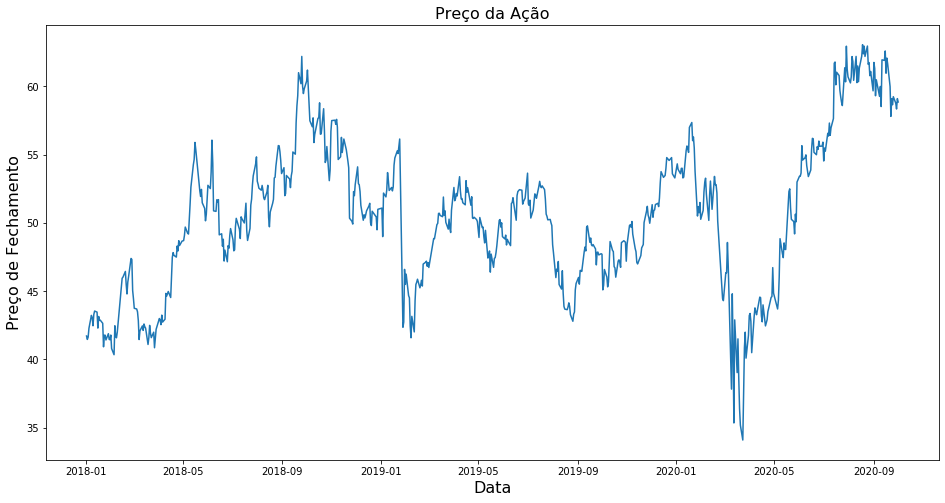

In [104]:
plt.figure(figsize=(16,8))
plt.title('Preço da Ação',fontsize=16)
plt.plot(df['Close'])
plt.xlabel('Data',fontsize=16)
plt.ylabel('Preço de Fechamento',fontsize=16)
plt.show()

# 3.0.Data Preparation

C:\Users\cemarcosi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


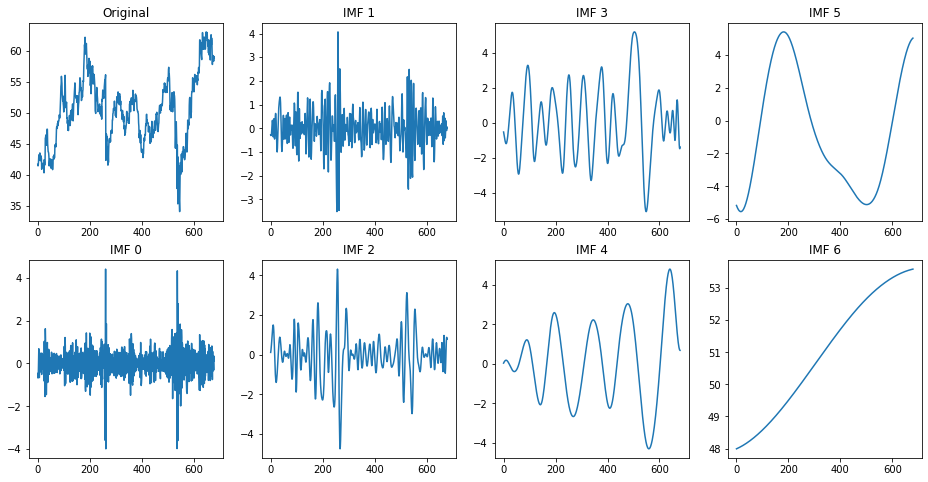

In [105]:
# aplicar teorema de embutir de Takens para transformar para o espaço fase, ou seja, sair de Tempo vs X(Tempo) para
# X(t) e X(t+1). Isso mostrar que cada valor tem dependencia temporal, no exemplo um ponto tem dependencia em um 
# instante de tempo do outro valor.
# x(t) x(t+5) x(t+10) conjunto determinístico, cada valor depende de dois valores deslocados 5 instancias de tempo no passado
serie = np.array(df['Close'])
# Calcular a ACF (Auto-Correlation Function) para determinar dependencia temporal (produto interno com ela mesma)
results = acf(serie, unbiased=True, nlags=1000)
#plot_acf(serie, lags=100)
# Fazer EMD (Empirical Mode Decomposition), separar Estocástico de Determinístico
emd = EMD()
IMFs = emd(serie)
fig, axs = plt.subplots(2, 4,figsize=(16,8))
#fig, axs = plt.subplots(len(IMFs)+1,figsize=(16,32))
contador = 0
for i in range(0,4):
    for j in range(0,2):
        if (i==0 and j==0):
            axs[0,0].plot(serie)
            axs[0, 0].set_title('Original')
        else:
            axs[j,i].plot(IMFs[contador])
            axs[j,i].set_title('IMF {}'.format(contador))
            contador = contador + 1

C:\Users\cemarcosi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\cemarcosi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\cemarcosi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\cemarcosi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\cemarcosi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWar

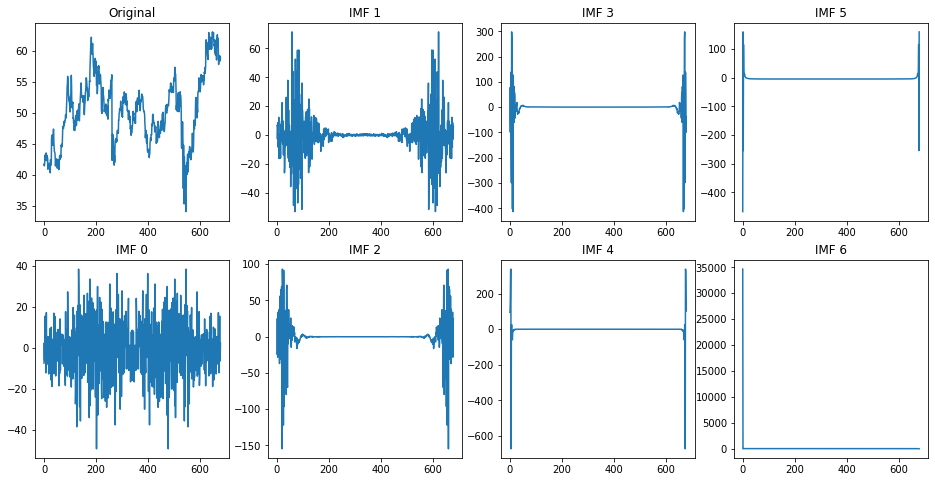

In [106]:
#fig, axs = plt.subplots(len(IMFs)+1,figsize=(16,32))
#axs[0].plot(serie)
#for i in range(0,len(IMFs)):
#    axs[i+1].plot(fft(IMFs[i]))

fig, axs = plt.subplots(2, 4,figsize=(16,8))
#fig, axs = plt.subplots(len(IMFs)+1,figsize=(16,32))
contador = 0
for i in range(0,4):
    for j in range(0,2):
        if (i==0 and j==0):
            axs[0,0].plot(serie)
            axs[0, 0].set_title('Original')
        else:
            axs[j,i].plot(fft(IMFs[contador]))
            axs[j,i].set_title('IMF {}'.format(contador))
            contador = contador + 1

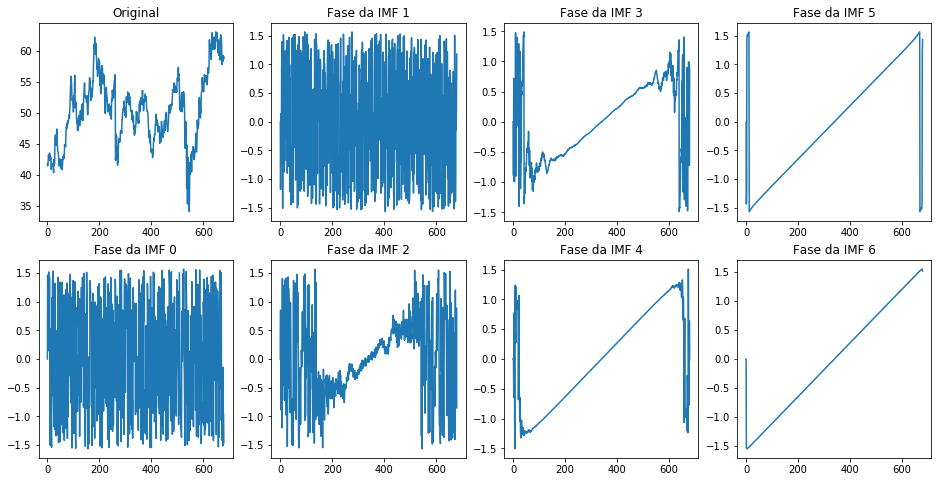

In [107]:
#fig, axs = plt.subplots(len(IMFs)+1,figsize=(16,32))
#axs[0].plot(serie)
#fase = [None] * len(IMFs)
#for i in range(0,len(IMFs)):
#    fourier = fft(IMFs[i])
#    fase[i] = np.arctan((np.imag(fourier)/np.real(fourier)))
#    axs[i+1].plot(fase[i])
    
fig, axs = plt.subplots(2, 4,figsize=(16,8))
#fig, axs = plt.subplots(len(IMFs)+1,figsize=(16,32))
contador = 0
fase = [None] * len(IMFs)
for i in range(0,4):
    for j in range(0,2):
        if (i==0 and j==0):
            axs[0,0].plot(serie)
            axs[0, 0].set_title('Original')
        else:
            fourier = fft(IMFs[contador])
            fase[contador] = np.arctan((np.imag(fourier)/np.real(fourier)))
            axs[j,i].plot(fase[contador])
            axs[j,i].set_title('Fase da IMF {}'.format(contador))
            contador = contador + 1

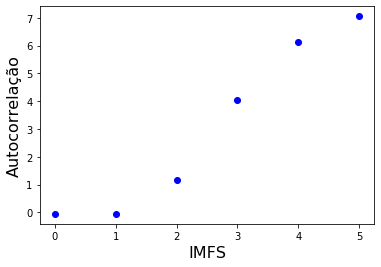

In [112]:
# calculando mutual information para determinar corte de deterministico e estocástico
valores = [None] * len(fase)
for i in range(0,len(fase)-1):
    valores[i] = ee.mi(fase[i],fase[i+1])
plt.plot(valores, 'bo')
plt.ylabel('Autocorrelação',fontsize=16)
plt.xlabel('IMFS',fontsize=16)

# Compondo parte determinística a partir do corte
deterministico = IMFs[2:].sum(axis=0)

Text(0.5, 0, 'Amostras')

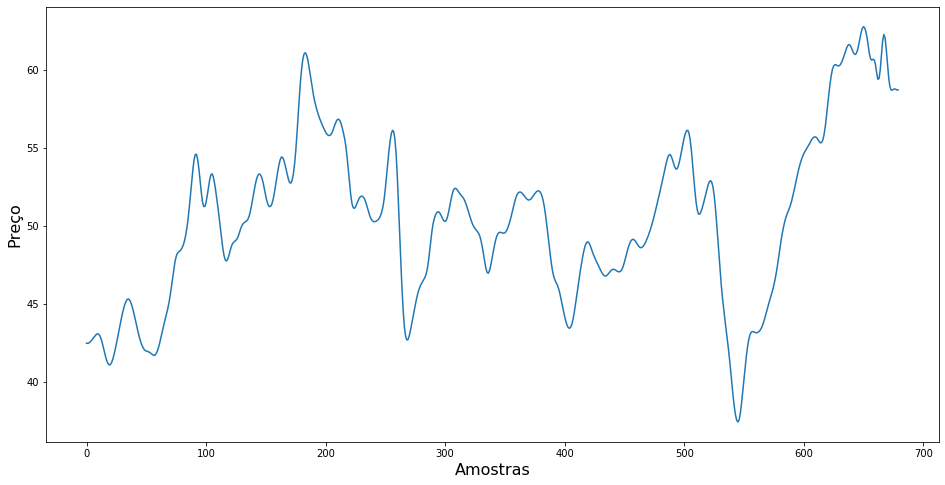

In [114]:
plt.figure(figsize=(16,8))
plt.plot(deterministico)
plt.ylabel('Preço',fontsize=16)
plt.xlabel('Amostras',fontsize=16)

8


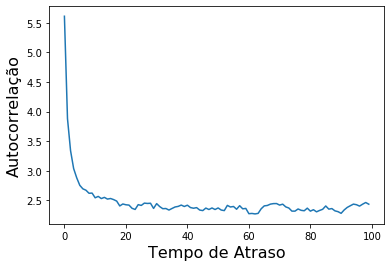

In [113]:
# calculando ami
mi = delay.dmi(deterministico, maxtau=100)
vetor = []
for i in range(0,90):
    if (mi[i+1]-mi[i]) > 0:
        vetor.append(i)
d = vetor[0]
plt.plot(mi)
plt.ylabel('Autocorrelação',fontsize=16)
plt.xlabel('Tempo de Atraso',fontsize=16)
print(d)

Text(0, 0.5, 'Falsos Vizinhos')

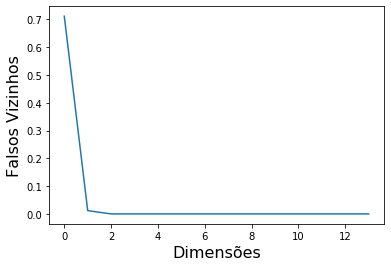

In [111]:
# calculando fnn (nesse deu 3 o m)
dim = np.arange(1, 15)
m = dimension.fnn(deterministico, tau=1, dim=dim, window=10, metric='euclidean')[2]
plt.plot(m)
plt.xlabel('Dimensões',fontsize=16)
plt.ylabel('Falsos Vizinhos',fontsize=16)

In [35]:
# agora calcular Takens
def takensEmbedding (data, delay, dimension):
    "This function returns the Takens embedding of data with delay into dimension, delay*dimension must be < len(data)"
    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceed length of data!')    
    embeddedData = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embeddedData;

espaco_fase = takensEmbedding(deterministico,d,3);

In [36]:
x_treino = np.vstack((espaco_fase[2],espaco_fase[1])).ravel('F')
x_treino = x_treino.reshape(-1,2)
y_treino = espaco_fase[0]
x_treino = np.array(x_treino)
x_treino = x_treino.reshape(-1,2)
#print("Essa é a entrada para o treino: \n",x_treino)
#print("Essa é a saída do treino: \n",y_treino)

In [37]:
x_teste = [[0],[0]]
x_teste[1] = espaco_fase[0][-d]
x_teste[0] = espaco_fase[1][-d]
x_teste = np.array(x_teste)
x_teste = x_teste.reshape(-1, 2)
#print("Esse é a entrada de valor para prever: \n",x_teste)

# 4.0. Machine Learning Model

In [38]:
# Modelo Random Forest
from sklearn.ensemble import RandomForestRegressor
modelo = RandomForestRegressor(n_estimators = 1000, random_state = 42)
modelo.fit(x_treino, y_treino)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [39]:
qtd_previsao = 10
resultados = np.vstack((espaco_fase[2],espaco_fase[1],espaco_fase[0])).ravel('F')
resultados = resultados.reshape(-1,3)
for i in range(len(resultados),len(resultados)+qtd_previsao):
    predictions = float(modelo.predict(resultados[i-d][0:2].reshape(-1,2)))
    newrow = [resultados[i-d][1],resultados[i-d][2],predictions]
    resultados = np.vstack([resultados, newrow])

In [58]:
# Modelo SVM
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#modelo = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
modelo = SVR(kernel='rbf', C=1000.0, gamma=0.0001)
#modelo = SVR(kernel='linear', C=1000.0)
#modelo = SVR(kernel='poly', C=1000.0, degree=2)
modelo.fit(x_treino, y_treino)

SVR(C=1000.0, gamma=0.0001)

In [59]:
qtd_previsao = 10
resultados = np.vstack((espaco_fase[2],espaco_fase[1],espaco_fase[0])).ravel('F')
resultados = resultados.reshape(-1,3)
for i in range(len(resultados),len(resultados)+qtd_previsao):
    predictions = float(modelo.predict(resultados[i-d][0:2].reshape(-1,2)))
    newrow = [resultados[i-d][1],resultados[i-d][2],predictions]
    resultados = np.vstack([resultados, newrow])

In [50]:
# Modelo boosted decision trees e Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

rng = np.random.RandomState(1)

# Fit regression model
modelo_decisionTree = DecisionTreeRegressor(max_depth=4)
modelo_boostedTree = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=300, random_state=rng)

modelo_decisionTree.fit(x_treino, y_treino)
modelo_boostedTree.fit(x_treino, y_treino)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x2C12090158)

In [51]:
qtd_previsao = 10
resultados = np.vstack((espaco_fase[2],espaco_fase[1],espaco_fase[0])).ravel('F')
resultados = resultados.reshape(-1,3)
for i in range(len(resultados),len(resultados)+qtd_previsao):
    predictions = float(modelo_boostedTree.predict(resultados[i-d][0:2].reshape(-1,2)))
    newrow = [resultados[i-d][1],resultados[i-d][2],predictions]
    resultados = np.vstack([resultados, newrow])

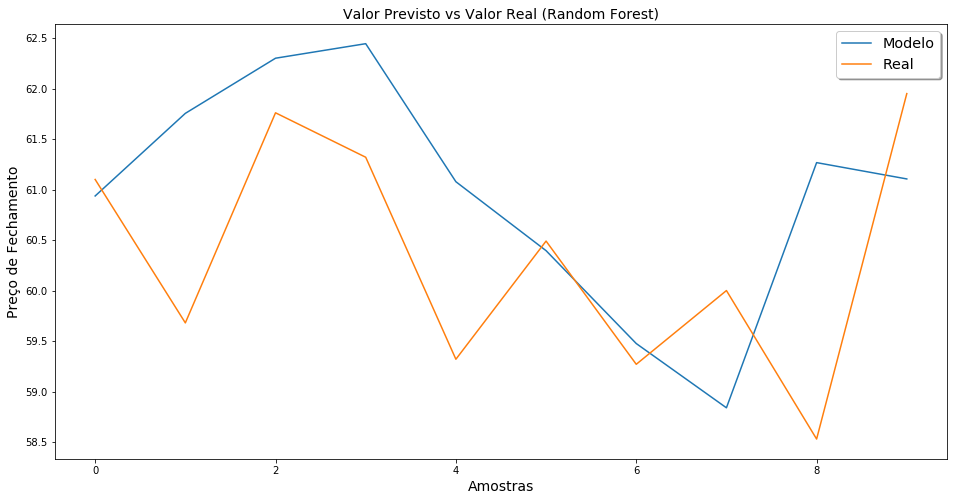

In [40]:
real = df['Close']
real = real[len(resultados)-qtd_previsao:len(resultados)].tolist()
plt.figure(figsize=(16,8))
plt.title('Valor Previsto vs Valor Real (Random Forest)',fontsize=14)
plt.plot(resultados[len(resultados)-qtd_previsao:len(resultados):, 2],label='Modelo')
plt.plot(real, label = 'Real')
plt.xlabel('Amostras',fontsize=14)
plt.ylabel('Preço de Fechamento',fontsize=14)
legend = plt.legend(shadow=True, fontsize='x-large')
legend.get_frame()
plt.show()

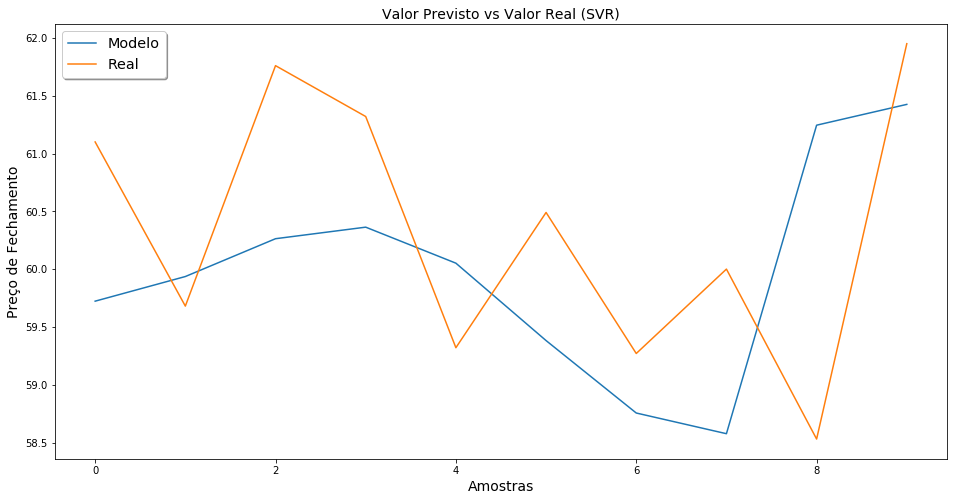

In [60]:
real = df['Close']
real = real[len(resultados)-qtd_previsao:len(resultados)].tolist()
plt.figure(figsize=(16,8))
plt.title('Valor Previsto vs Valor Real (SVR)',fontsize=14)
plt.plot(resultados[len(resultados)-qtd_previsao:len(resultados):, 2],label='Modelo')
plt.plot(real, label = 'Real')
plt.xlabel('Amostras',fontsize=14)
plt.ylabel('Preço de Fechamento',fontsize=14)
legend = plt.legend(shadow=True, fontsize='x-large')
legend.get_frame()
plt.show()

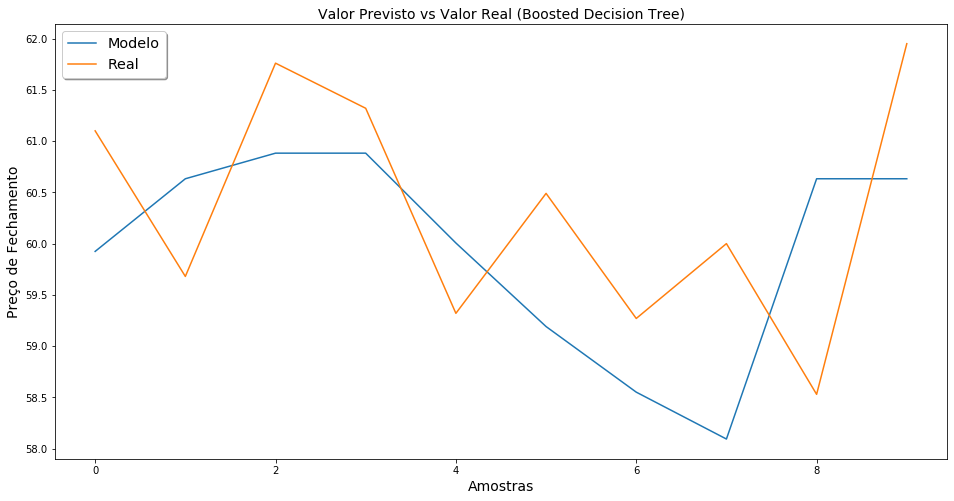

In [52]:
real = df['Close']
real = real[len(resultados)-qtd_previsao:len(resultados)].tolist()
plt.figure(figsize=(16,8))
plt.title('Valor Previsto vs Valor Real (Boosted Decision Tree)',fontsize=14)
plt.plot(resultados[len(resultados)-qtd_previsao:len(resultados):, 2],label='Modelo')
plt.plot(real, label = 'Real')
plt.xlabel('Amostras',fontsize=14)
plt.ylabel('Preço de Fechamento',fontsize=14)
legend = plt.legend(shadow=True, fontsize='x-large')
legend.get_frame()
plt.show()

# 5.0. Machine Learning Model Performance

In [43]:
#Calcular Mean Squared Error (MSE), Mean Absolut Error (MAE), Root Mean Squared Error (RMSE), 
#Mean Absolut Deviation (MAD), Mean Absolut Percentage Error (MAPE)
#Modelo Random Forest

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import stats
import statistics
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pred = (resultados[len(resultados)-qtd_previsao:len(resultados):, 2]).tolist()

diff = []

for i in range(0,len(real)):
    diff.append(real[i]-pred[i])

MSE = mean_squared_error(real, pred)
MAE = mean_absolute_error(real, pred)
RMSE = sqrt(MSE)
MAD = stats.median_abs_deviation(diff)
MAPE = mean_absolute_percentage_error(real,pred)
print('===================MODELO RANDOM FOREST========================')
print('Mean Squared Error: %f' % MSE)
print('Mean Absolut Error: %f' % MAE)
print('Root Mean Squared Error: %f' % RMSE)
print('Mean Absolut Deviation: %f' % MAD)
print('Mean Absolut Percentage Error: %f' % MAPE)

===================MODELO RANDOM FOREST========================
Mean Squared Error: 1.857756
Mean Absolut Error: 1.070315
Root Mean Squared Error: 1.362995
Mean Absolut Deviation: 0.984540
Mean Absolut Percentage Error: 1.789296


In [61]:
#Calcular Mean Squared Error (MSE), Mean Absolut Error (MAE), Root Mean Squared Error (RMSE), 
#Mean Absolut Deviation (MAD), Mean Absolut Percentage Error (MAPE)
#Modelo SVR

pred = (resultados[len(resultados)-qtd_previsao:len(resultados):, 2]).tolist()

for i in range(0,len(real)):
    diff.append(real[i]-pred[i])

MSE = mean_squared_error(real, pred)
MAE = mean_absolute_error(real, pred)
RMSE = sqrt(MSE)
MAD = stats.median_abs_deviation(diff)
MAPE = mean_absolute_percentage_error(real,pred)
print('===================MODELO SVR========================')
print('Mean Squared Error: %f' % MSE)
print('Mean Absolut Error: %f' % MAE)
print('Root Mean Squared Error: %f' % RMSE)
print('Mean Absolut Deviation: %f' % MAD)
print('Mean Absolut Percentage Error: %f' % MAPE)

===================MODELO SVR========================
Mean Squared Error: 1.682207
Mean Absolut Error: 1.110569
Root Mean Squared Error: 1.296999
Mean Absolut Deviation: 1.118028
Mean Absolut Percentage Error: 1.846068


In [53]:
#Calcular Mean Squared Error (MSE), Mean Absolut Error (MAE), Root Mean Squared Error (RMSE), 
#Mean Absolut Deviation (MAD), Mean Absolut Percentage Error (MAPE)
#Modelo Boosted Decision Tree

pred = (resultados[len(resultados)-qtd_previsao:len(resultados):, 2]).tolist()

for i in range(0,len(real)):
    diff.append(real[i]-pred[i])

MSE = mean_squared_error(real, pred)
MAE = mean_absolute_error(real, pred)
RMSE = sqrt(MSE)
MAD = stats.median_abs_deviation(diff)
MAPE = mean_absolute_percentage_error(real,pred)
print('===================MODELO BOOSTED DECISION TREE========================')
print('Mean Squared Error: %f' % MSE)
print('Mean Absolut Error: %f' % MAE)
print('Root Mean Squared Error: %f' % RMSE)
print('Mean Absolut Deviation: %f' % MAD)
print('Mean Absolut Percentage Error: %f' % MAPE)

===================MODELO BOOSTED DECISION TREE========================
Mean Squared Error: 1.571516
Mean Absolut Error: 1.147335
Root Mean Squared Error: 1.253601
Mean Absolut Deviation: 1.266756
Mean Absolut Percentage Error: 1.906730


In [93]:
# Realizar a validação de acordo com diferença do dia anterior e posterior
# Quanto abriu e quanto fechou
real

[61.099998474121094,
 59.68000030517578,
 61.7599983215332,
 61.31999969482422,
 59.31999969482422,
 60.4900016784668,
 59.27000045776367,
 60.0,
 58.529998779296875,
 61.95000076293945]

In [95]:
teste_real = []
for i in range(1,len(real)):
    teste_real.append(real[i-1] - real[i])
teste_real

[1.4199981689453125,
 -2.079998016357422,
 0.4399986267089844,
 2.0,
 -1.1700019836425781,
 1.220001220703125,
 -0.7299995422363281,
 1.470001220703125,
 -3.420001983642578]

In [97]:
teste_pred = []
for i in range(1,len(pred)):
    teste_pred.append(pred[i-1] - pred[i])
teste_pred

[-0.21306018319296527,
 -0.3271929184526243,
 -0.09990362253392959,
 0.3114928395964398,
 0.6695532781774318,
 0.6266992368491628,
 0.178961213689945,
 -2.668829996322529,
 -0.17993493160167873]

In [101]:
result = []
for i in range(0,len(pred)-1):
    if(teste_real[i]>0 and teste_pred[i]>0 or teste_real[i]<0 and teste_pred[i]<0):
        result.append(1)
    else:
        result.append(0)

In [102]:
result

[0, 1, 0, 1, 0, 1, 0, 0, 1]

Minima of delayed mutual information = [ 5 20 31 45 58 70 83 96]
Autocorrelation time = 10


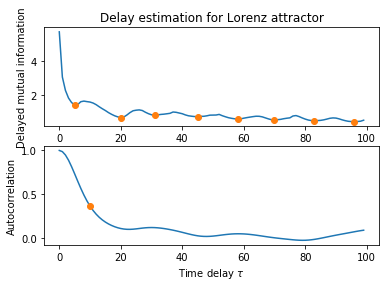

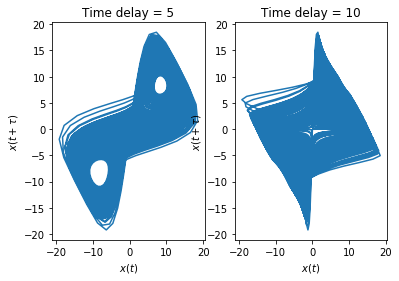

In [103]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""Time delay estimation for time series from the Lorenz attractor.
The first minimum of the delayed mutual information occurs at 5 and the
autocorrelation time is 11.  A better choice is provided by the mutual
information curve.  If one plots the 2D phase portrait of the attractor
with a delay of 11, one can see that it's overfolded.  Note that both
these values depend on the sampling time used and should not be taken as
"universal" time delays for reconstructing the Lorenz attractor.
"""

import numpy as np
import matplotlib.pyplot as plt
from nolitsa import data, delay, noise


def localmin(x):
    """Return all local minima from the given data set.
    Returns all local minima from the given data set.  Note that even
    "kinky" minima (which are probably not real minima) will be
    returned.
    Parameters
    ----------
    x : array
        1D scalar data set.
    Returns
    -------
    i : array
        Array containing location of all local minima.
    """
    return (np.diff(np.sign(np.diff(x))) > 0).nonzero()[0] + 1


x = data.lorenz()[1][:, 0]

# Compute autocorrelation and delayed mutual information.
lag = np.arange(100)
r = delay.acorr(x, maxtau=100)
i = delay.dmi(x, maxtau=100)

# While looking for local minima in the DMI curve, it's useful to do an
# SMA to remove "kinky" minima.
i_delay = localmin(noise.sma(i, hwin=1)) + 1
r_delay = np.argmax(r < 1.0 / np.e)

print(r'Minima of delayed mutual information = %s' % i_delay)
print(r'Autocorrelation time = %d' % r_delay)

plt.figure(1)

plt.subplot(211)
plt.title(r'Delay estimation for Lorenz attractor')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, i, i_delay, i[i_delay], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, r, r_delay, r[r_delay], 'o')

plt.figure(2)
plt.subplot(121)
plt.title(r'Time delay = %d' % i_delay[0])
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(x[:-i_delay[0]], x[i_delay[0]:])

plt.subplot(122)
plt.title(r'Time delay = %d' % r_delay)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(x[:-r_delay], x[r_delay:])

plt.show()